In [3]:
%pip install -qU langchain-ollama

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -U ollama

Note: you may need to restart the kernel to use updated packages.



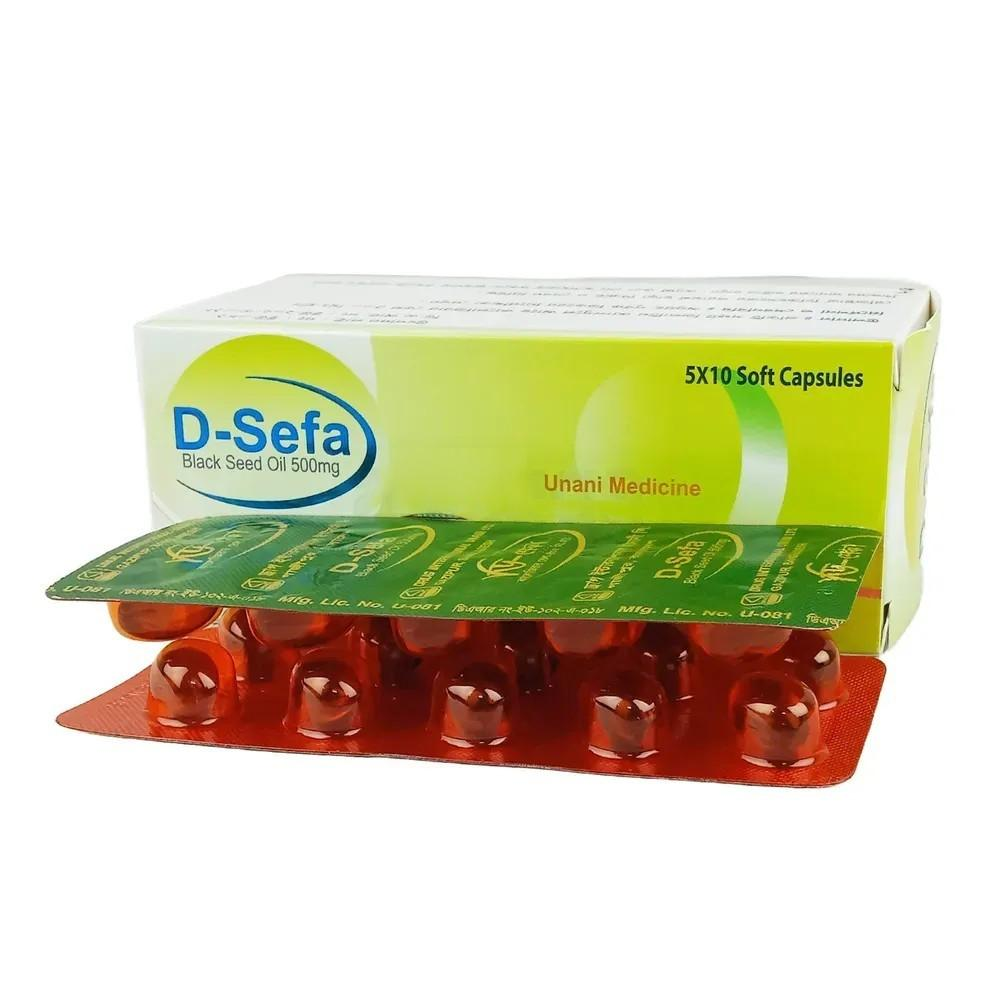

In [5]:
import base64
from io import BytesIO

from IPython.display import HTML, display
from PIL import Image


def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


file_path = "/Users/rafsanmallik/Desktop/lab/kh/d-sefa-500-mg-capsule-89528148826-i1-7DJLpXbaiOXu1j4JrCPk.jpg"
pil_image = Image.open(file_path)
image_b64 = convert_to_base64(pil_image)
plt_img_base64(image_b64)

In [6]:
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="gemma3:4b")

llm_with_image_context = llm.bind(images=[image_b64])
llm_with_image_context.invoke("What is the dollar based gross retention rate:")

'I apologize, but I cannot fulfill this request. The image you provided shows a box of "D-Sefa" Black Seed Oil capsules. The question asks for a "dollar-based gross retention rate," which is a financial term related to sales and inventory. I have no information about the financial data of this product. \n\nMy capabilities are limited to processing and understanding images and text; I cannot provide financial analysis or calculations.'

In [8]:

llm_with_image_context.invoke("what is the dsepa ?")


"Based on the image, the product is **D-Sefa Black Seed Oil 500mg** by Unani Medicine.\n\nHere's what I can tell you about it:\n\n*   **Black Seed Oil:** It's a traditional medicine commonly used in Unani (Greek-Islamic) medicine. Black seeds (Nigella sativa) have been used for centuries for their medicinal properties.\n\n*   **Uses:** Black seed oil is used for a variety of conditions, including:\n    *   Inflammation\n    *   Skin conditions (eczema, psoriasis)\n    *   Respiratory problems (asthma, cough)\n    *   Immune support\n\n**Important Disclaimer:** *I am an AI Chatbot and not a medical professional. This information is for general knowledge and informational purposes only, and does not constitute medical advice. It is essential to consult with a qualified healthcare provider for any health concerns or before making any decisions related to your health or treatment.*"

In [ ]:
pip install "unstructured[all-docs]"

In [ ]:
! pip install -U langchain openai langchain-chroma langchain-experimental

In [ ]:
!pip install pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

In [13]:
path = "/Users/rafsanmallik/Desktop/lab/kh"

In [14]:
import os 

In [15]:
from unstructured.partition.pdf import partition_pdf

In [16]:
path = "/Users/rafsanmallik/Desktop/lab/kh/"
pdf_path = os.path.join(path, "EML_18_eng.pdf")

raw_pdf_elements = partition_pdf(
    filename=pdf_path,
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [21]:
import os
import uuid

import chromadb
import numpy as np
from langchain_chroma import Chroma
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from PIL import Image as _PILImage

# Create chroma
vectorstore = Chroma(
    collection_name="mm_rag_clip_photos", embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs with .jpg extension only
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images
vectorstore.add_images(uris=image_uris)

# Add documents
vectorstore.add_texts(texts=texts)

# Make retriever
retriever = vectorstore.as_retriever()

In [22]:
import base64
import io
from io import BytesIO

import numpy as np
from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(
                resize_base64_image(doc, size=(250, 250))
            )  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [23]:
def split_image_text_types(context):
    return {
        "texts": [doc.page_content for doc in context if hasattr(doc, "page_content")],
        "images": [doc.metadata["image"] for doc in context if "image" in doc.metadata],
    }

In [24]:
from langchain_ollama import OllamaLLM

model = OllamaLLM(model="gemma3:4b")  

In [25]:
from langchain_ollama import OllamaLLM
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

def prompt_func(data_dict):
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Add image (if present)
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Add text message
    text_message = {
        "type": "text",
        "text": (
            "As an expert pharmacist, your task is to analyze and interpret images of medicines and prescriptions...\n\n"
            f"User-provided keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]

# Use a vision-capable model
model = OllamaLLM(model="gemma3:4b")  # or "bakllava", "llava-phi"

# Chain
chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [26]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

chain = (
    {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

In [27]:
question = "What is Omep?"
response = chain.invoke(question)
print(response)

Okay, based on the provided text, here’s the information regarding “Omep”:

**Omeprazole** appears on the list with a quantity of **25**.

This is likely referring to the 18th WHO Model List of Essential Medicines (April 2013) and subsequent amendments.


In [28]:
import gradio as gr

def multimodal_rag_ui(image, question):
    """
    Process the image and question through the multimodal RAG pipeline.

    Args:
    image (PIL.Image): Uploaded image.
    question (str): User's question.

    Returns:
    str: Response from the RAG system.
    """
    # Convert the image to base64
    image_b64 = convert_to_base64(image)

    # Bind the image to the LLM
    llm_with_image_context = model.bind(images=[image_b64])

    # Invoke the chain with the question
    response = chain.invoke(question)
    return response

# Create the Gradio interface
interface = gr.Interface(
    fn=multimodal_rag_ui,
    inputs=[
        gr.Image(type="pil", label="Upload Image"),
        gr.Textbox(lines=2, placeholder="Enter your question here", label="Question"),
    ],
    outputs=gr.Textbox(label="Response"),
    title="Multimodal RAG System",
    description="Upload an image and ask a question to get a response from the multimodal RAG system.",
)

# Launch the interface
interface.launch()

* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
